In [1]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [2]:
%%time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
# from bert import tokenization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
inception = InceptionV3(weights='imagenet')

CPU times: total: 3.39 s
Wall time: 17.1 s


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
%%time
df_train = pd.read_json('Data/train.jsonl', lines=True)
df_train.head()

CPU times: total: 31.2 ms
Wall time: 213 ms


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [5]:
len(df_train)

8500

In [6]:
%%time
img = []
# print(df_train.count())
for i in range(0, df_train.shape[0]):
#     print(i)
    im = image.load_img("Data/" + df_train["img"][i], target_size=(224,224))
    img.append(im)

CPU times: total: 21.3 s
Wall time: 4min 1s


In [7]:
from tensorflow.keras.applications import ResNet50
incept_model = ResNet50(include_top=True)

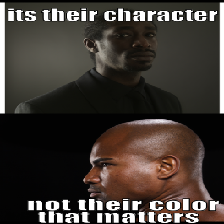

In [8]:
img[0]

In [9]:
%%time
for i in range(df_train.shape[0]):
    x = image.img_to_array(img[i])
    x = np.array([x])
    
    x = preprocess_input(x)
    preds = inception.predict(x)
    predicted = decode_predictions(preds, top = 5)[0]
    for j in range(0, 5):

        df_train["text"][i] = df_train["text"][i] + " " + predicted[j][1]
    

# print("Predicted: ", decode_predictions(preds, top = 3)[0])

ValueError: in user code:

    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer inception_v3: expected shape=(None, 299, 299, 3), found shape=(None, 224, 224, 3)


In [ ]:
print(df_train["text"][2])

putting bows on your pet Egyptian_cat tiger_cat tabby Siamese_cat window_screen


In [ ]:
df_train

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matte...
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet Egyptian_cat tiger_ca...
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me book_jacket ...
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
    return model

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train.text, df_train.label, test_size=0.2, random_state=42)

In [13]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
train_input = bert_encode(X_train.values, tokenizer, max_len=160)
test_input = bert_encode(X_test.values, tokenizer, max_len=160)
train_labels = y_train.values

In [17]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

6800 1700 6800 1700


In [18]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

C:\Users\yasir\anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
from keras import backend as K
K.clear_session()

In [26]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
                    
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.3,
    epochs=50,
    callbacks=[checkpoint],
    batch_size=8,
    steps_per_epoch=12
)

Epoch 1/50


TypeError: 'NoneType' object is not callable

In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
y_actual = list(y_test)
y_prob = list(test_pred.reshape(len(test_pred), ))
print("AUC: ", roc_auc_score(y_actual, y_prob))

In [25]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [26]:
FMS = pd.read_csv("Image_caption/Data/FHM_image_captions.csv")
FMS.head()

,image,gen_caption
0,89527.png,two men in blue and white are standing in fron...
1,89541.png,two men are standing in front of large building .
2,89632.png,man in blue shirt is sitting in front of his h...
3,89621.png,man in white shirt and blue shirt is standing ...
4,89543.png,man in red shirt and blue shirt is smiling .


In [27]:
FMS['id'] = ''

In [28]:
FMS

,image,gen_caption,id
0,89527.png,two men in blue and white are standing in fron...,
1,89541.png,two men are standing in front of large building .,
2,89632.png,man in blue shirt is sitting in front of his h...,
3,89621.png,man in white shirt and blue shirt is standing ...,
4,89543.png,man in red shirt and blue shirt is smiling .,
...,...,...,...
9783,09563.png,dog is jumping over hurdle in the grass .,
9784,09527.png,two men are standing in front of large tree .,
9785,10328.png,woman and man are smiling and holding drink an...,
9786,09687.png,man in white shirt and white shirt is sitting ...,


In [29]:
for i in range (FMS.shape[0]):
    FMS['id'][i] = FMS['image'][i][:-4]

In [30]:
FMS_Final = pd.merge(df_train, FMS, on = "id")

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [15]:
df_train["id"] = df_train["id"].astype(int)
FMS["id"] = FMS["id"].astype(int)

In [34]:
FMS_final = FMS_Final.drop_duplicates()

In [36]:
FMS_final.to_csv("FMS_final.csv", index = False)

In [ ]:


FMS.shape

In [13]:
df_train.shape

(8500, 4)

In [14]:
FMS[image] = "img" + FMS[image]

KeyError: <module 'keras.api._v2.keras.preprocessing.image' from 'C:\\Users\\yasir\\anaconda3\\envs\\tensorflow_env\\lib\\site-packages\\keras\\api\\_v2\\keras\\preprocessing\\image\\__init__.py'>

In [15]:
FMS

,image,gen_caption
0,89527.png,two men in blue and white are standing in fron...
1,89541.png,two men are standing in front of large building .
2,89632.png,man in blue shirt is sitting in front of his h...
3,89621.png,man in white shirt and blue shirt is standing ...
4,89543.png,man in red shirt and blue shirt is smiling .
...,...,...
9783,09563.png,dog is jumping over hurdle in the grass .
9784,09527.png,two men are standing in front of large tree .
9785,10328.png,woman and man are smiling and holding drink an...
9786,09687.png,man in white shirt and white shirt is sitting ...
